In [13]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error, roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import torch
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sparse
from torch_geometric.data import HeteroData
from torch_geometric.nn import HANConv, Linear
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
FOLDER_PATH = "/home/juan/Work/Midterm project/splited"
X_PATH = os.path.join(FOLDER_PATH, "X_data.npz")
Y_PATH = os.path.join(FOLDER_PATH, "Y_data.npz")
COLS_PATH = os.path.join(FOLDER_PATH, "feature_names.json")

In [15]:
if not os.path.exists(X_PATH) or not os.path.exists(Y_PATH):
    
    FILE_PATTERN = os.path.join(FOLDER_PATH, "processed_*.csv")
    file = sorted(glob.glob(FILE_PATTERN)) # All processed file in the FOLDER_PATH

    # Use first file to determine column structure
    f_df = pd.read_csv(file[0], nrow = 3)
    cols = f_df.columns
    x_cols = [c for c in cols if c.startswith("x ")]
    y_cols = [c for c in cols if c.startswith("y ")]

    with open(COLS_PATH, 'w') as f:
        json.dum(x_cols, f)

    X_list = []
    Y_list = []

    # Convert to Sparse
    for f in files:
        df = pd.read_csv(f)

        x_data = df[x_cols].fillna(0).values.astype(np.float32)
        y_data = df[y_cols].fillna(0).values.astype(np.float32)

        X_list.append(sparse.csr_matrix(x_data))
        Y_list.append(sparse.csr_matrix(y_data))

        del df, x_data, y_data
        
    X_final = sparse.vstack(X_list)
    Y_final = sparse.vstack(Y_list)

    sparse.save_npz(X_PATH, X_final)
    sparse.save_npz(Y_PATH, Y_final)

In [16]:
#LOAD DATA

X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

num_patients = X.shape[0]
num_input_features = X.shape[1]
num_reactions = Y.shape[1]

print(num_patients)
print(num_input_features)
print(num_reactions)

# Split
indices = np.arange(num_patients)
# print(indices)
train_idx, test_idx = train_test_split(indices, test_size = 0.2, random_state = 1)

661271
5286
10488


In [17]:
torch.cuda.is_available()

True

In [18]:
class HeteroGraphDataset(Dataset):
    def __init__(self, X, Y, indices, num_input_nodes, num_output_nodes):
        self.X = X
        self.Y = Y
        self.indices = indices
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.indices[idx]

def graph_collate_fn(batch_indices):
    batch_indices = sorted(batch_indices)
    
    x_sub = X[batch_indices]
    y_sub = Y[batch_indices] 
    
    batch_size = len(batch_indices)

    rows_d, cols_d = x_sub.nonzero()
    edge_index_drug = torch.stack([torch.from_numpy(rows_d), torch.from_numpy(cols_d)]).long()
    
    rows_r, cols_r = y_sub.nonzero()
    edge_index_react = torch.stack([torch.from_numpy(rows_r), torch.from_numpy(cols_r)]).long()
    
    data = HeteroData()
    
    # Nodes
    data['patient'].x = torch.ones((batch_size, 1), dtype=torch.float)
    data['patient'].num_nodes = batch_size
    
    data['drug'].num_nodes = num_input_features
    data['reaction'].num_nodes = num_reactions
    
    # Edges
    data['patient', 'takes', 'drug'].edge_index = edge_index_drug
    data['patient', 'has_reaction', 'reaction'].edge_index = edge_index_react
    
    # Reverse Edges 
    data['drug', 'taken_by', 'patient'].edge_index = torch.flip(edge_index_drug, [0])
    data['reaction', 'reaction_in', 'patient'].edge_index = torch.flip(edge_index_react, [0])
    
    return data

batch_size = 1024 
train_ds = HeteroGraphDataset(X, Y, train_idx, num_input_features, num_reactions)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=graph_collate_fn, num_workers=0)

In [19]:
train_ds = HeteroGraphDataset(X, Y, train_idx, num_input_features, num_reactions)
train_ds

In [20]:
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, collate_fn=graph_collate_fn, num_workers=0)
train_loader

In [29]:
class HeteroHAN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata, num_heads=2):
        super().__init__()

        self.han_conv1 = HANConv(in_channels=hidden_channels, out_channels=hidden_channels, heads=num_heads, dropout=0.2, metadata=metadata)
        
        self.han_conv2 = HANConv(in_channels=hidden_channels, out_channels=out_channels, heads=num_heads, dropout=0.2, metadata=metadata)

    def forward(self, x_dict, edge_index_dict):
        x = self.han_conv1(x_dict, edge_index_dict)
        x = {k: v.relu() for k, v in x.items()}
        
        x = self.han_conv2(x, edge_index_dict)
        return x

# Define Metadata (Graph Schema)
metadata = (
    ['patient', 'drug', 'reaction'],
    [('patient', 'takes', 'drug'), 
     ('drug', 'taken_by', 'patient'),
     ('patient', 'has_reaction', 'reaction'),
     ('reaction', 'reaction_in', 'patient')]
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HeteroHAN(hidden_channels=64, out_channels=64, metadata=metadata, num_heads=2).to(device)

# Embeddings
drug_emb = torch.nn.Embedding(num_input_features + 1, 64).to(device)
react_emb = torch.nn.Embedding(num_reactions + 1, 64).to(device)
patient_lin = Linear(1, 64).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(drug_emb.parameters()) + list(react_emb.parameters()) + list(patient_lin.parameters()), 
    lr=0.01
)

print("HeteroHAN Model Initialized.")

HeteroHAN Model Initialized.


In [30]:
THRESHOLD = 0.8

In [31]:
history = {
    'ts' : [],
    'tp' : [],
    'tr' : [],
    'tf1' : []
}

In [32]:
# Start training
eps = 1e-5

In [33]:



prev_avg_loss = float('inf') 

while True:
    model.train()
    total_loss = 0
    total_examples = 0
    total_tp, total_fp, total_fn = 0, 0, 0

    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()

        x_dict = {
            'patient' : patient_lin(batch['patient'].x),
            'drug' : drug_emb(torch.arange(num_input_features, device=device)), 
            'reaction' : react_emb(torch.arange(num_reactions, device=device))
        }

        out = model(x_dict, batch.edge_index_dict)

        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index

        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]

        pos_score = (src_emb * dst_emb).sum(dim=-1)

        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_score),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_score = (src_emb * neg_dst_emb).sum(dim=-1)

        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        
        loss = F.binary_cross_entropy_with_logits(scores, labels)

        loss.backward()
        optimizer.step()

        # Metrics
        with torch.no_grad():
            pos_probs = pos_score.sigmoid()
            neg_probs = neg_score.sigmoid()

            tp = (pos_probs > THRESHOLD).sum().item()
            fn = (pos_probs <= THRESHOLD).sum().item()
            fp = (neg_probs > THRESHOLD).sum().item()

            total_tp += tp
            total_fn += fn
            total_fp += fp
            
            total_loss += loss.item() * batch['patient'].num_nodes
            total_examples += batch['patient'].num_nodes

    avg_loss = total_loss / total_examples
            
    loss_diff = abs(prev_avg_loss - avg_loss)
    if loss_diff < eps:
        print(f"Converged. Final Loss: {avg_loss}")
        break
    
    prev_avg_loss = avg_loss

    epsilon = 1e-9
    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    history['ts'].append(avg_loss)
    history['tf1'].append(f1)

    print(f"loss {avg_loss:.4f} Prec: {precision:.4f} Rec: {recall:.4f} f1:{f1:.4f}")

loss 0.4431 Prec: 0.9491 Rec: 0.8933 f1:0.9204
loss 0.4340 Prec: 0.9591 Rec: 0.9046 f1:0.9311
loss 0.4321 Prec: 0.9604 Rec: 0.9093 f1:0.9342
loss 0.4314 Prec: 0.9605 Rec: 0.9121 f1:0.9357
loss 0.4300 Prec: 0.9612 Rec: 0.9154 f1:0.9377
loss 0.4298 Prec: 0.9614 Rec: 0.9165 f1:0.9384
loss 0.4297 Prec: 0.9613 Rec: 0.9167 f1:0.9385
loss 0.4294 Prec: 0.9616 Rec: 0.9172 f1:0.9389
loss 0.4294 Prec: 0.9615 Rec: 0.9168 f1:0.9386
loss 0.4289 Prec: 0.9616 Rec: 0.9189 f1:0.9398
loss 0.4292 Prec: 0.9614 Rec: 0.9188 f1:0.9396
loss 0.4286 Prec: 0.9617 Rec: 0.9203 f1:0.9405
loss 0.4292 Prec: 0.9612 Rec: 0.9188 f1:0.9396
loss 0.4282 Prec: 0.9620 Rec: 0.9199 f1:0.9405
loss 0.4287 Prec: 0.9615 Rec: 0.9203 f1:0.9404
loss 0.4285 Prec: 0.9619 Rec: 0.9196 f1:0.9403
loss 0.4287 Prec: 0.9616 Rec: 0.9199 f1:0.9403
loss 0.4283 Prec: 0.9618 Rec: 0.9211 f1:0.9410
loss 0.4293 Prec: 0.9614 Rec: 0.9177 f1:0.9391
loss 0.4284 Prec: 0.9617 Rec: 0.9216 f1:0.9412
Converged. Final Loss: 0.42843811695998313


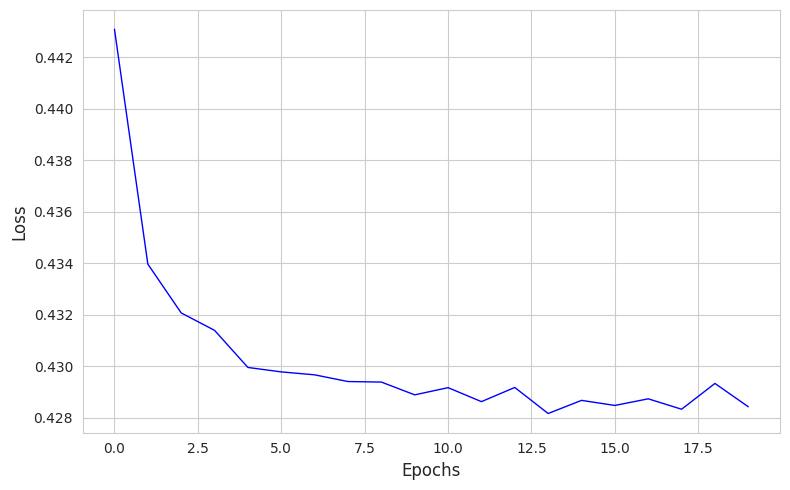

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

plt.plot(
    history['ts'],
    marker='',
    color='blue',
    linewidth=1
)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.tight_layout()
plt.savefig("train_loss.png")
plt.show()

In [35]:
test_ds = HeteroGraphDataset(X, Y, test_idx, num_input_features, num_reactions)
test_loader = DataLoader(test_ds, batch_size = 1024, shuffle=True, collate_fn=graph_collate_fn, num_workers=0)

In [36]:
model.eval()

HeteroHAN(
  (han_conv1): HANConv(64, heads=2)
  (han_conv2): HANConv(64, heads=2)
)

In [37]:
import numpy as np

model.eval()
total_test_tp = 0
total_test_fp = 0
total_test_fn = 0

all_y_true = []
all_y_scores = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        x_dict = {
            'patient': patient_lin(batch['patient'].x),
            'drug': drug_emb(torch.arange(num_input_features, device=device)),
            'reaction': react_emb(torch.arange(num_reactions, device=device))
        }
        
        out = model(x_dict, batch.edge_index_dict)
        
        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]
        
        pos_score = (src_emb * dst_emb).sum(dim=-1)
        
        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_score),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_score = (src_emb * neg_dst_emb).sum(dim=-1)
        
        pos_probs = pos_score.sigmoid()
        neg_probs = neg_score.sigmoid()
        
        batch_scores = torch.cat([pos_probs, neg_probs]).cpu().numpy()
        batch_labels = torch.cat([torch.ones_like(pos_probs), torch.zeros_like(neg_probs)]).cpu().numpy()
        
        all_y_scores.append(batch_scores)
        all_y_true.append(batch_labels)

        tp = (pos_probs > THRESHOLD).sum().item()
        fn = (pos_probs <= THRESHOLD).sum().item()
        fp = (neg_probs > THRESHOLD).sum().item() 
        
        total_test_tp += tp
        total_test_fp += fp
        total_test_fn += fn

all_y_true = np.concatenate(all_y_true)
all_y_scores = np.concatenate(all_y_scores)

epsilon = 1e-9
test_precision = total_test_tp / (total_test_tp + total_test_fp + epsilon)
test_recall = total_test_tp / (total_test_tp + total_test_fn + epsilon)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + epsilon)

print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

   Precision: 0.9743
   Recall:    0.7037
   F1-Score:  0.8172


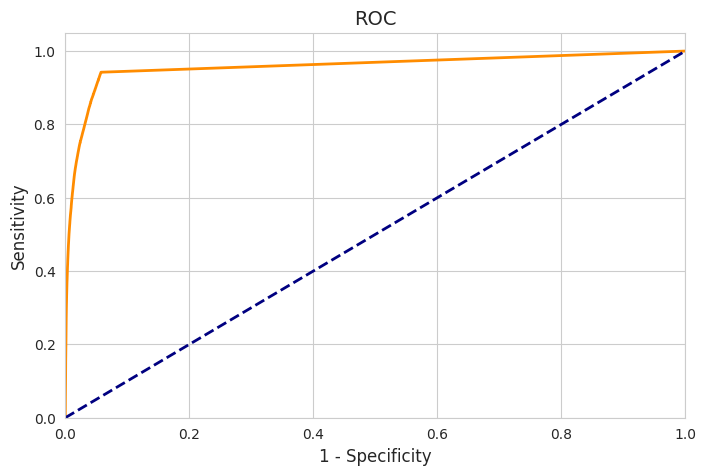

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=12)
plt.ylabel('Sensitivity', fontsize=12)
plt.title("ROC", fontsize=14)
plt.grid(True)


plt.savefig('roc_curve.png')
plt.show()